# PyTorch Tabular tutorial

This notebook gives an overview how to work with [PytochTabular](https://github.com/manujosephv/pytorch_tabular) which provides all tools for working with DL tabular data models.

Basically, PyTorch Tabular aims to make Deep Learning with Tabular data easy and accessible to real-world cases and research alike. The core principles behind the design of the library are:

* Low Resistance Useability

* Easy Customization

* Scalable and Easier to Deploy

* It has been built on the shoulders of giants like PyTorch(obviously), and PyTorch Lightning.

Installation.

In [1]:
!pip install "pandas<3.0"
!pip install -U pytorch_tabular

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

In [4]:
import warnings
# Suppress all user warnings
warnings.filterwarnings("ignore")

# Download the Data

Today we will work with [Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing ) from UCI ML Repository.

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

In [5]:
np.random.seed(42)

X, y = fetch_openml("Bank_marketing_data_set_UCI", version=1, as_frame=True, return_X_y=True)
data = X.join(y)
del X, y
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign',
       'previous', 'poutcome']

num_cols = ['age', 'balance', 'duration', 'pdays']
target=["y"]

In [7]:
train, test = train_test_split(data, stratify=data["y"], test_size=0.2, random_state=42)

# LightGBM

Let us start with a simple LightGBM baseline.

In [8]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

# LightGBM needs categorical columns encoded as integers
train_enc = train.copy()
test_enc = test.copy()
for col in cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", encoded_missing_value=np.nan, unknown_value=np.nan)
    train_enc[col] = enc.fit_transform(train_enc[col].values.reshape(-1,1))
    test_enc[col] = enc.transform(test_enc[col].values.reshape(-1,1))

In [9]:
clf = LGBMClassifier(random_state=42)
clf.fit(train_enc.drop(columns=target[0]), train_enc[target], categorical_feature=cat_cols)
test_pred = clf.predict(test_enc.drop(columns=target[0]))
test_pred_proba = clf.predict_proba(test_enc.drop(columns=target[0]))

acc = accuracy_score(test[target[0]].values, test_pred)
loss = log_loss(test[target[0]].values, test_pred_proba)
print(f"Acc: {acc} | LogLoss: {loss}")

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
Acc: 0.9083268826716797 | LogLoss: 0.19783125832611875


0.90 Accuracy, not bad. Let us look if DL models can beat it!

# PyTorch Tabular

In [10]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import (
    CategoryEmbeddingModelConfig,
    FTTransformerConfig,
    TabNetModelConfig,
    GatedAdditiveTreeEnsembleConfig,
    TabTransformerConfig,
    AutoIntConfig
)
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

## Common Configs    

These are common configs which can be reused. Since the datamodule is very quick, we can just stick with the high-level API

In [11]:
data_config = DataConfig(
    target=target, #target should always be a list.
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
)

for col in data_config.continuous_cols:
    train[col] = train[col].astype("float64")
    test[col] = test[col].astype("float64")

trainer_config = TrainerConfig(
#     auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=256,
    max_epochs=500,
    early_stopping="valid_loss", # Monitor valid_loss for early stopping
    early_stopping_mode = "min", # Set the mode as min because for val_loss, lower is better
    early_stopping_patience=5, # No. of epochs of degradation training will wait before terminating
    checkpoints="valid_loss", # Save best checkpoint monitoring val_loss
    load_best=True, # After training, load the best checkpoint
)

optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming"
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

## CategoryEmbedding


Simple category encoding.

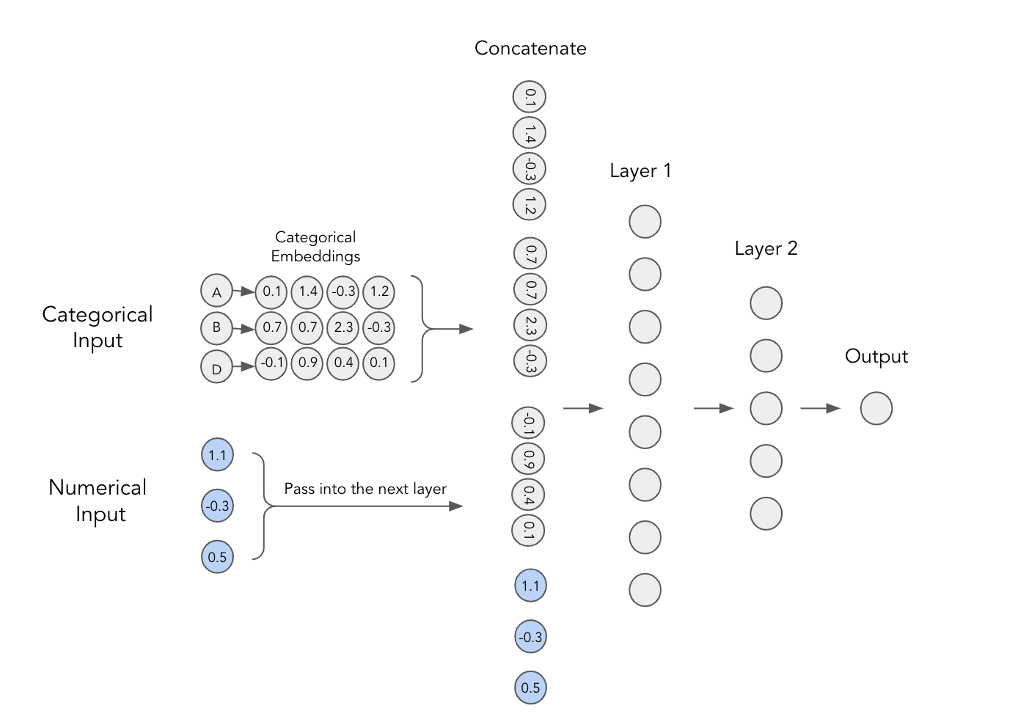

Image from the [post](https://towardsdatascience.com/transformers-for-tabular-data-tabtransformer-deep-dive-5fb2438da820).

In [12]:
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="64-32",  # Number of nodes in each layer
    activation="ReLU", # Activation between each layers
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: CategoryEmbeddingModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  8.2 K │
│ 1 │ _embedding_layer │ Embedding1dLayer          │  2.7 K │
│ 2 │ head             │ LinearHead                │     66 │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │
└───┴──────────────────┴───────────────────────────┴────────┘

Trainable params: 10.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.9 K                                                                                               
Total estimated model params size (MB): 0

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9016919136047363     │
│         test_loss         │    0.2202438861131668     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2202438861131668, 'test_accuracy': 0.9016919136047363}]

## TabTransformer    

TabTransformer architexture from [Paper](https://arxiv.org/abs/2012.06678). The idea is to contextualize categorical embeddings by passing them through the Transformer Encoder.

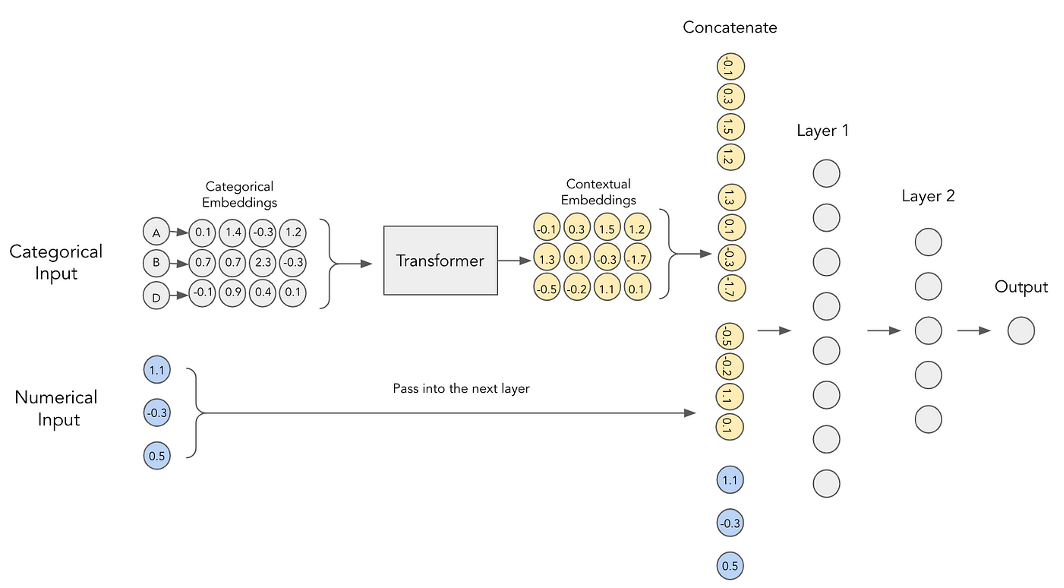

Image from the [post](https://towardsdatascience.com/transformers-for-tabular-data-tabtransformer-deep-dive-5fb2438da820).

In [ ]:
model_config = TabTransformerConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │  5.6 K │
│ 2 │ _head            │ LinearHead             │    778 │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 277 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 277 K                                                                                                
Total estimated model params size (MB): 1

Output()

## FT Transformer

FT Transformers architecture from [Revisiting Deep Learning Models for Tabular Data](https://arxiv.org/abs/2106.11959). It further develops the idea of TabTransformer by additionall embedding Numerical features and contextualizing them via the Transformer encoder block.

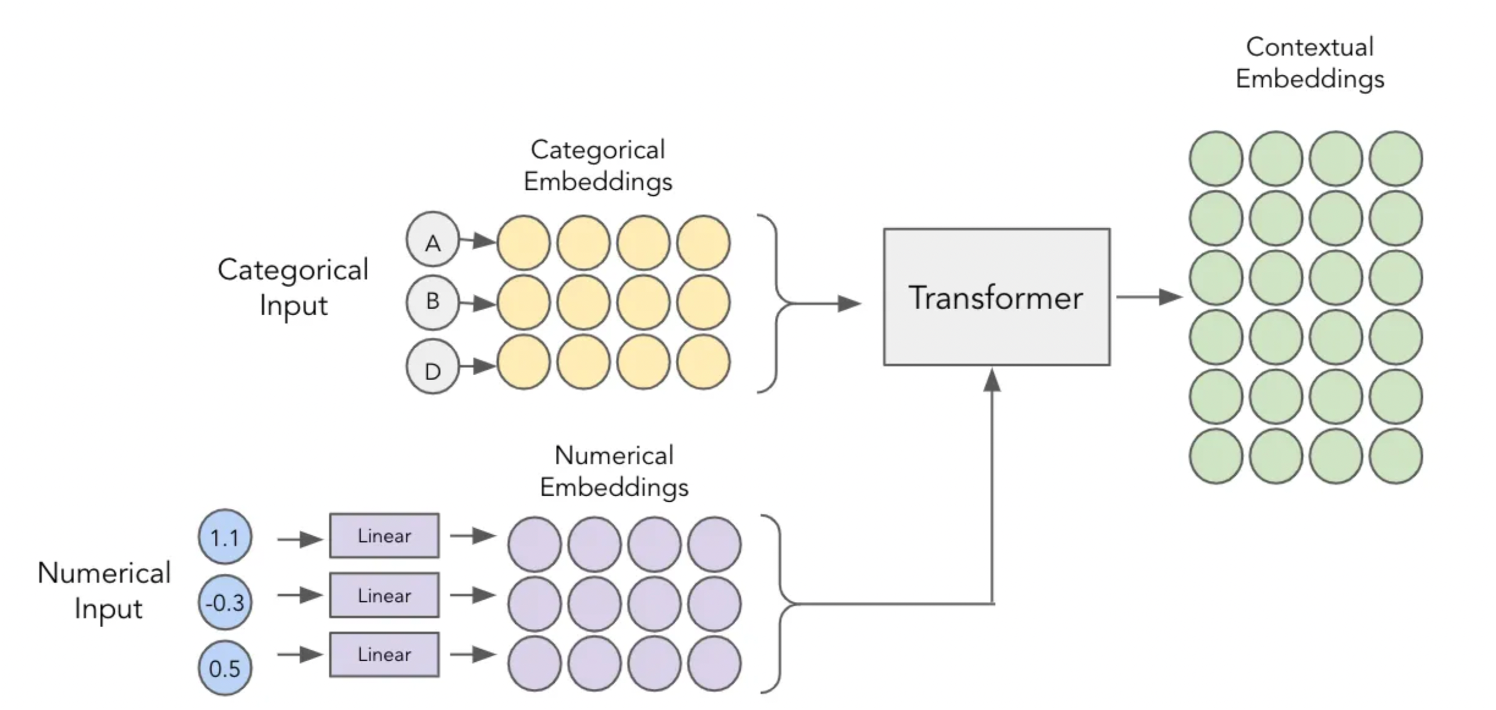

Image from the [post](https://towardsdatascience.com/improving-tabtransformer-part-1-linear-numerical-embeddings-dbc3be3b5bb5).

In addition we add [CLS] token embedding to the feature embeddings. It is then passed to Transformers as well and whose contextualized representation is used for final prediction.

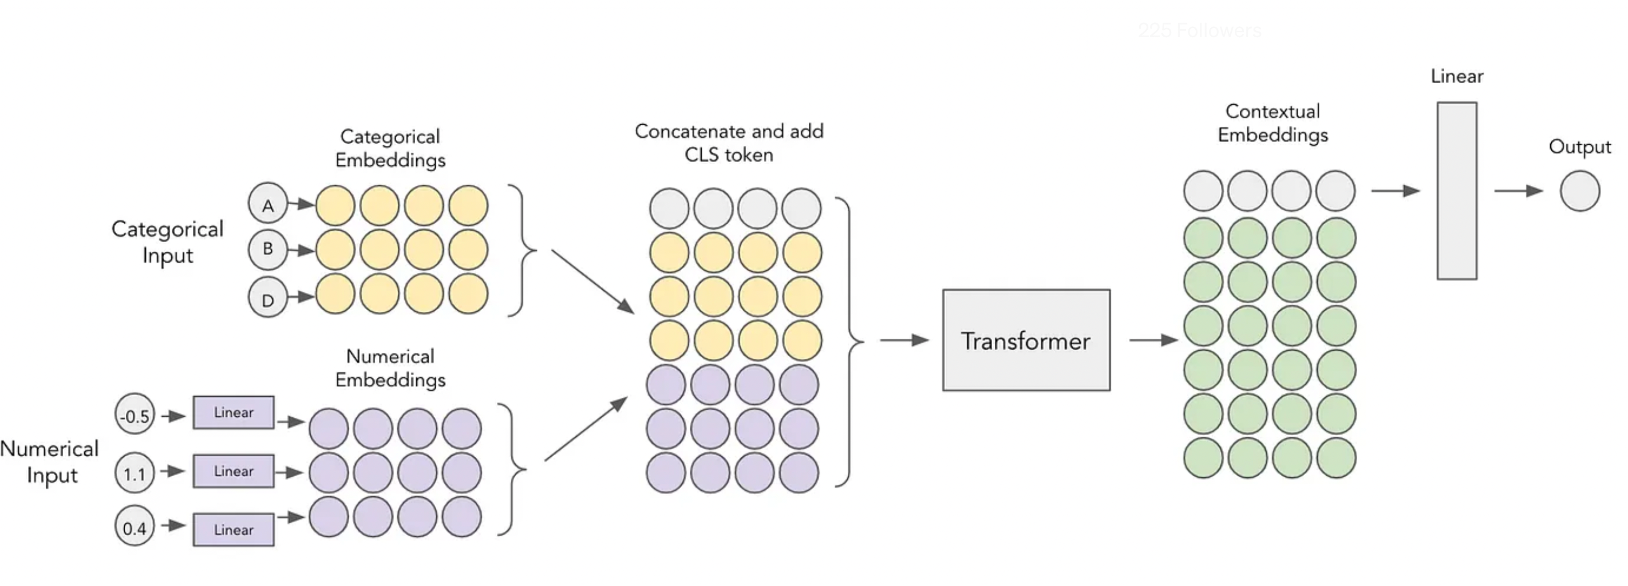

Image from the [post](https://towardsdatascience.com/improving-tabtransformer-part-1-linear-numerical-embeddings-dbc3be3b5bb5).

In [ ]:
model_config = FTTransformerConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: FTTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                  ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ FTTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer      │  6.2 K │
│ 2 │ _head            │ LinearHead            │     66 │
│ 3 │ loss             │ CrossEntropyLoss      │      0 │
└───┴──────────────────┴───────────────────────┴────────┘

Trainable params: 277 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 277 K                                                                                                
Total estimated model params size (MB): 1

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.908105731010437     │
│         test_loss         │    0.20246368646621704    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.20246368646621704, 'test_accuracy': 0.908105731010437}]

## TabNet    

TabNet from [TabNet: Attentive Interpretable Tabular Learning
](https://arxiv.org/abs/1908.07442) paper.

In [ ]:
model_config = TabNetModelConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

2023-01-17 17:33:44,441 - {pytorch_tabular.tabular_model:101} - INFO - Experiment Tracking is turned off
Global seed set to 42
2023-01-17 17:33:44,453 - {pytorch_tabular.tabular_model:463} - INFO - Preparing the DataLoaders
2023-01-17 17:33:44,459 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for classification task
2023-01-17 17:33:44,616 - {pytorch_tabular.tabular_model:506} - INFO - Preparing the Model: TabNetModel
2023-01-17 17:33:44,645 - {pytorch_tabular.tabular_model:262} - INFO - Preparing the Trainer
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-01-17 17:33:44,689 - {pytorch_tabular.tabular_model:561} - INFO - Training Started
/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/manujosephv/pytorc

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │
│ 1 │ _backbone        │ TabNetBackbone   │ 14.5 K │
│ 2 │ _head            │ Identity         │      0 │
│ 3 │ loss             │ CrossEntropyLoss │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 14.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.5 K                                                                                               
Total estimated model params size (MB): 0

Output()

/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

2023-01-17 17:37:46,206 - {pytorch_tabular.tabular_model:563} - INFO - Training the model completed
2023-01-17 17:37:46,206 - {pytorch_tabular.tabular_model:1174} - INFO - Loading the best model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8845515847206116     │
│         test_loss         │    0.28120988607406616    │
└───────────────────────────┴───────────────────────────┘
Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36/36 0:00:00 • 0:00:00 56.94it/s

[{'test_loss': 0.28120988607406616, 'test_accuracy': 0.8845515847206116}]

## Bonus: GATE - not Transformer-based but popular for Tabular data
  
### Full architecture

First DL baseline we're going to try today is [GATE](https://arxiv.org/pdf/2207.08548.pdf). GATE is high-performance, parameter and computationally efficient deep learning
architecture for tabular data, Gated Additive Tree
Ensemble(GATE).

GATE uses a gating mechanism, inspired from GRU, as a feature representation learning unit with an in-built feature selection mechanism.


GATE combines it with an ensemble of differentiable, non-linear decision trees,
re-weighted with simple self-attention to predict
our desired output.

As long as GATE is not a Transformer-based model, we do not study it in detail on this course, but you may find all necessary details in the [original paper](https://arxiv.org/pdf/2207.08548.pdf).




GATE proposes two configuration, a Full (larger) model and a lite (smaller) model.

In [ ]:
model_config = GatedAdditiveTreeEnsembleConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36/36 0:01:44 • 0:00:00 0.36it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9071104526519775     │
│         test_loss         │    0.2159498631954193     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2159498631954193, 'test_accuracy': 0.9071104526519775}]

## GATE (lite)

In [ ]:
model_config = GatedAdditiveTreeEnsembleConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    gflu_stages=4,
    num_trees=30,
    tree_depth=5,
    chain_trees=False
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

2023-01-17 16:57:57,436 - {pytorch_tabular.tabular_model:101} - INFO - Experiment Tracking is turned off
Global seed set to 42
2023-01-17 16:57:57,448 - {pytorch_tabular.tabular_model:463} - INFO - Preparing the DataLoaders
2023-01-17 16:57:57,453 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for classification task
2023-01-17 16:57:57,621 - {pytorch_tabular.tabular_model:506} - INFO - Preparing the Model: GatedAdditiveTreeEnsembleModel
2023-01-17 16:57:57,756 - {pytorch_tabular.tabular_model:262} - INFO - Preparing the Trainer
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-01-17 16:57:57,800 - {pytorch_tabular.tabular_model:561} - INFO - Training Started
/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ GatedAdditiveTreesBackbone │  701 K │
│ 1 │ _embedding_layer │ Embedding1dLayer           │  2.7 K │
│ 2 │ _head            │ CustomHead                 │     96 │
│ 3 │ loss             │ CrossEntropyLoss           │      0 │
└───┴──────────────────┴────────────────────────────┴────────┘

Trainable params: 704 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 704 K                                                                                                
Total estimated model params size (MB): 2

Output()

/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

2023-01-17 17:28:18,273 - {pytorch_tabular.tabular_model:563} - INFO - Training the model completed
2023-01-17 17:28:18,274 - {pytorch_tabular.tabular_model:1174} - INFO - Loading the best model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9045670628547668     │
│         test_loss         │    0.21413247287273407    │
└───────────────────────────┴───────────────────────────┘
Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36/36 0:00:22 • 0:00:00 1.57it/s

[{'test_loss': 0.21413247287273407, 'test_accuracy': 0.9045670628547668}]

## Bonus: AutoInt    

[Paper](https://arxiv.org/abs/1810.11921)

In [ ]:
model_config = AutoIntConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

2023-01-17 17:32:49,809 - {pytorch_tabular.tabular_model:101} - INFO - Experiment Tracking is turned off
Global seed set to 42
2023-01-17 17:32:49,825 - {pytorch_tabular.tabular_model:463} - INFO - Preparing the DataLoaders
2023-01-17 17:32:49,837 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for classification task
2023-01-17 17:32:50,008 - {pytorch_tabular.tabular_model:506} - INFO - Preparing the Model: AutoIntModel
2023-01-17 17:32:50,032 - {pytorch_tabular.tabular_model:262} - INFO - Preparing the Trainer
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-01-17 17:32:50,087 - {pytorch_tabular.tabular_model:561} - INFO - Training Started
/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/manujosephv/pytor

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ AutoIntBackbone  │ 13.8 K │
│ 1 │ _embedding_layer │ Embedding2dLayer │  3.1 K │
│ 2 │ _head            │ LinearHead       │  1.0 K │
│ 3 │ loss             │ CrossEntropyLoss │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 17.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 17.9 K                                                                                               
Total estimated model params size (MB): 0

Output()

/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

2023-01-17 17:33:31,016 - {pytorch_tabular.tabular_model:563} - INFO - Training the model completed
2023-01-17 17:33:31,017 - {pytorch_tabular.tabular_model:1174} - INFO - Loading the best model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/manujosephv/pytorch_tabular/.env/tabular_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9039035439491272     │
│         test_loss         │    0.21694879233837128    │
└───────────────────────────┴───────────────────────────┘
Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36/36 0:00:00 • 0:00:00 71.55it/s

[{'test_loss': 0.21694879233837128, 'test_accuracy': 0.9039035439491272}]